## 5. Problem 2: Larger unlabeled subset (Written Report)

In [228]:
import numpy as np

from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt

from sklearn.metrics import silhouette_score, silhouette_samples
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.style import rcmod
from yellowbrick.style.colors import resolve_colors

In [229]:
# ignore warning
import warnings 
warnings.simplefilter(action="ignore", category=plt.cbook.MatplotlibDeprecationWarning)
rcmod.reset_orig()

In [230]:
# load the data
path = "../01_data/data/p2_unsupervised/"
X_orig = np.load(path + "X.npy")
X = np.log2(X_orig+1)
print("1: Number of Cells (number of rows): {}".format(X.shape[0]))
print("1: Number of Genes (number of columns): {}".format(X.shape[1]))

print("2: largest entry in the first column of processed data: {:.7}".format(X[:,0].max()))

1: Number of Cells (number of rows): 2169
1: Number of Genes (number of columns): 45768
2: largest entry in the first column of processed data: 5.972169


## Data preparation

1. Reduce the dimensionality of the transformed date via PCA.
2. Split the dataset into different clusters (K-Means).
3. Set the number of clusters.

In [231]:
# fit the model with X and apply the dimensionality reduction, 
# in the following only the first 50 PC's will be used
X_PCA = PCA(n_components=500).fit_transform(X)

In [232]:
# calculate the WGSS for multiple cluster-models and the models itself
max_no_cluster = 50
X_KMeans = []
X_KMeans_models = []
WGSS = np.empty((max_no_cluster,2))
for i in np.arange(1, max_no_cluster+1, 1):
    print("{}%".format(float(i*100)/max_no_cluster+1), end='\r')
    WGSS[i-1,0] = i
    WGSS[i-1,1] = KMeans(n_clusters=i, n_init=10).fit(X_PCA[:,:50]).inertia_
    X_KMeans.append(KMeans(n_clusters=i, n_init=10).fit_predict(X_PCA[:,:49]))
    X_KMeans_models.append(KMeans(n_clusters=i, n_init=10).fit(X_PCA[:,:49]))

In [233]:
avg_silhouette_score = [silhouette_score(X_PCA[:,:49], X_KMeans_models[i].labels_) for i in range(1, max_no_cluster)]

0.2981426314020305


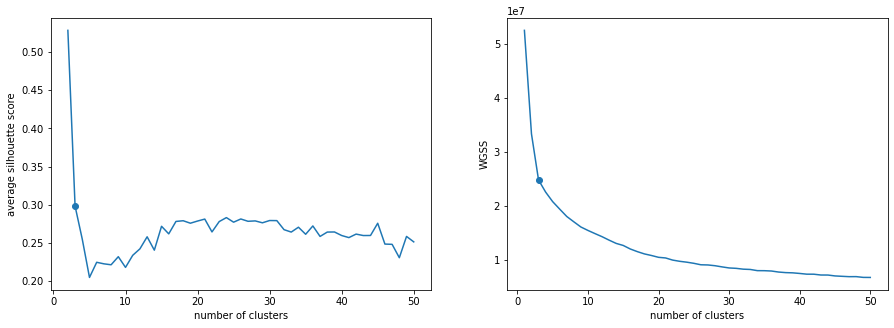

In [234]:
# print silhuoette score and elbow plot
print(avg_silhouette_score[1])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))

ax1.plot(np.arange(2,max_no_cluster+1), avg_silhouette_score)
ax1.scatter(3, avg_silhouette_score[1])
ax1.set_xlabel("number of clusters")
ax1.set_ylabel("average silhouette score")

ax2.plot(WGSS[:,0], WGSS[:,1])
ax2.scatter(3, WGSS[2,1])
ax2.set_xlabel("number of clusters")
ax2.set_ylabel("WGSS")
plt.show
plt.savefig("../03_report/problem_02/silhouette_elbow.png", dpi=300)

## Feature Selection

* We use 3 clusters as labels for a supervised learning problem.
* We use a logistical regression model
* We use the original data to do so.

In [235]:
# define the labels and split the data in train and test data sets 
y = X_KMeans_models[2].labels_
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

print(len(y_train))
print(len(y_test))

1453
716


In [236]:
# hyperparameter editing
param = ["l2", "l1"]
for i in param:
    clf = LogisticRegression(penalty=i, random_state=0, solver="liblinear", max_iter=100, verbose=1).fit(X_train, y_train)
    print("score of test data for parameter {}: {}" .format({i}, clf.score(X_test, y_test)))

[LibLinear]score of test data for parameter {'l2'}: 0.9958100558659218
[LibLinear]score of test data for parameter {'l1'}: 0.9958100558659218


In [237]:
# define the model
clf = LogisticRegression(penalty="l2", random_state=0, solver="liblinear", max_iter=100, verbose=1).fit(X_train, y_train)

[LibLinear]

In [238]:
# get the score of the model
print("score of training data: {:.3}" .format(clf.score(X_train, y_train)))
print("score of test data:     {:.3}" .format(clf.score(X_test, y_test)))

score of training data: 1.0
score of test data:     0.996


## Expansion of insights on greater data sets

1. Extract the 100 most important features from the data set.
2. Read new data set and transform it.
3. Train a logistic regression with the 100 selected features.
4. Test the model with the test data.
5. Repeat this procedure with a) 100 randomly chosen features, b) 100 features of highest variance.
6. Plot histograms of variance of corresponding variances. 

In [239]:
# extract the 100 most important features from above
features = np.argsort(np.sum(np.abs(clf.coef_),axis=0))[:100]

In [240]:
# read the data and transform it like before 
path = "../01_data/data/p2_evaluation/"
X_train = np.log2(np.load(path + "X_train.npy")+1)
X_test = np.log2(np.load(path + "X_test.npy")+1)
y_train = np.load(path + "y_train.npy")
y_test = np.load(path + "y_test.npy")

In [241]:
# feature selection of the 100 most important features of question 2.2
clf_0 = LogisticRegression(penalty='l2', random_state=0, solver='liblinear').fit(X_train[:,features], y_train)
print("score: {:.3}".format(clf_0.score(X_test[:,features], y_test)))

score: 0.153


In [242]:
# feature selection of 100 randomly chosen features

features_rand = np.random.randint(0, X_train.shape[1], 100)
clf_rand = LogisticRegression(penalty='l2', random_state=0, solver='liblinear').fit(X_train[:,features_rand], y_train)
print("score: {:.3}".format(clf_rand.score(X_test[:,features_rand], y_test)))

score: 0.303


In [254]:
# feature selection according to highest variance of features
features_var = np.argsort(np.var(X_train, axis=0))[-100:]
clf_var = LogisticRegression(penalty='l2', random_state=0, solver='liblinear').fit(X_train[:,features_var], y_train)
print("score: {:.3}".format(clf_var.score(X_test[:,features_var], y_test)))

score: 0.924


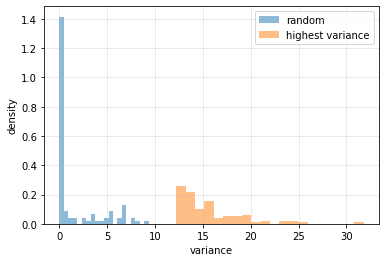

In [257]:
plt.hist(np.var(X_train[:,features_rand], axis=0), bins = 20, density=True, label="random", alpha=0.5)
plt.hist(np.var(X_train[:,features_var], axis=0), bins = 20, density=True, label="highest variance", alpha=0.5)
plt.legend()
plt.xlabel("variance")
plt.ylabel("density")
plt.grid(alpha=0.3)
plt.show
plt.savefig("../03_report/problem_02/historams_variance.png", dpi=300)